<a href="https://colab.research.google.com/github/cha-suyeon/SAM/blob/main/predictor_sample_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Example image

In [11]:
image = cv2.imread('/content/map.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

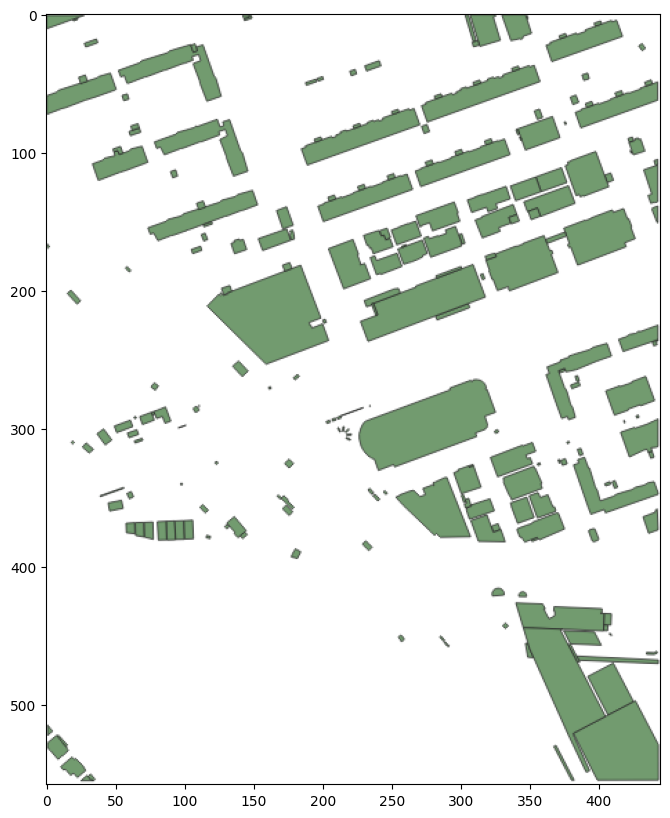

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [14]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [30]:
# input_point = np.array([[370, 470]])
input_point = np.array([[390, 435]])
input_label = np.array([1])

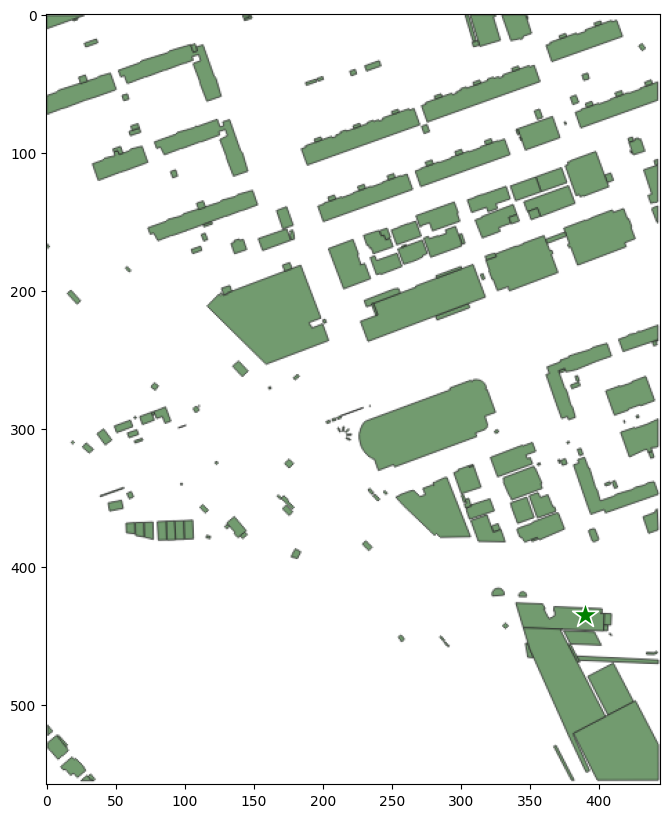

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [33]:
masks.shape  # (number_of_masks) x H x W

(3, 558, 445)

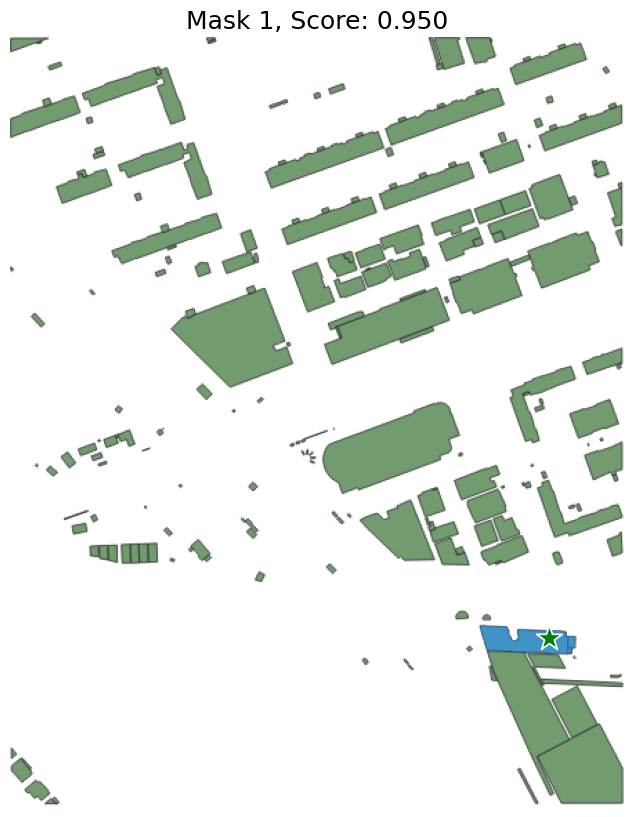

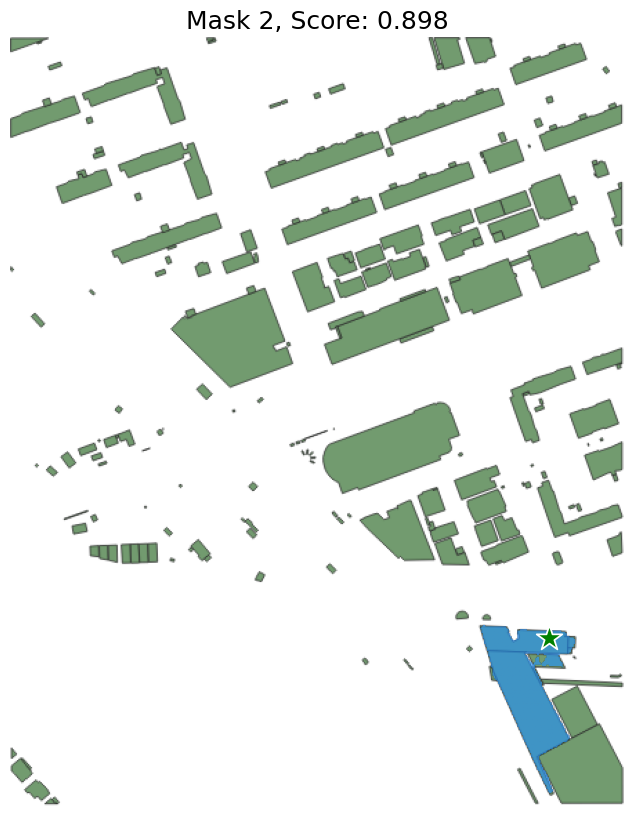

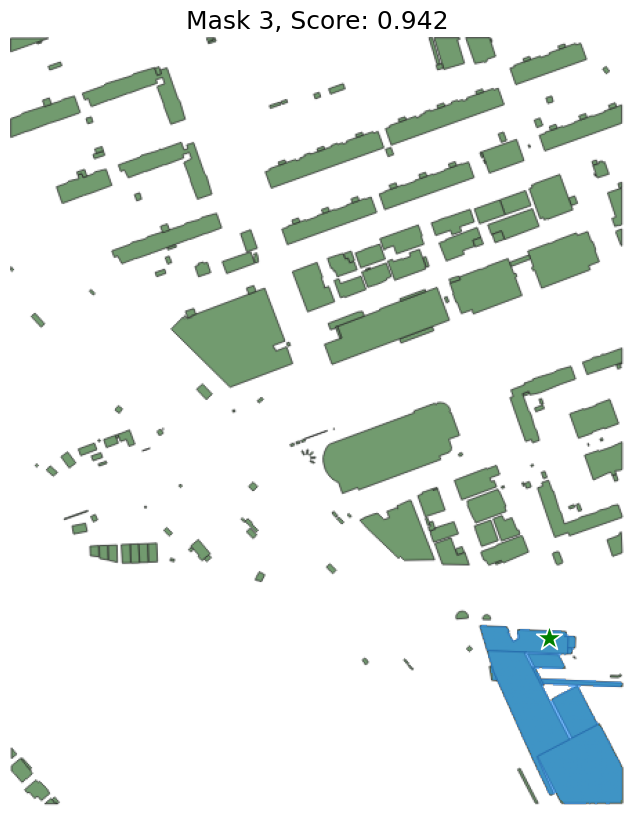

In [34]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [35]:
input_point = np.array([[370, 550], [390, 435]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [36]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [37]:
masks.shape

(1, 558, 445)

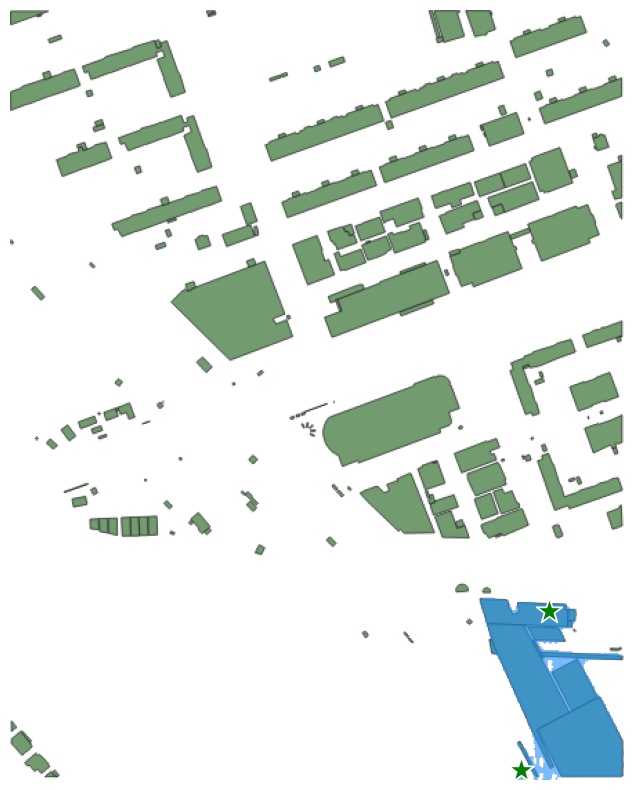

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [42]:
input_point = np.array([[370, 550], [390, 435]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [43]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

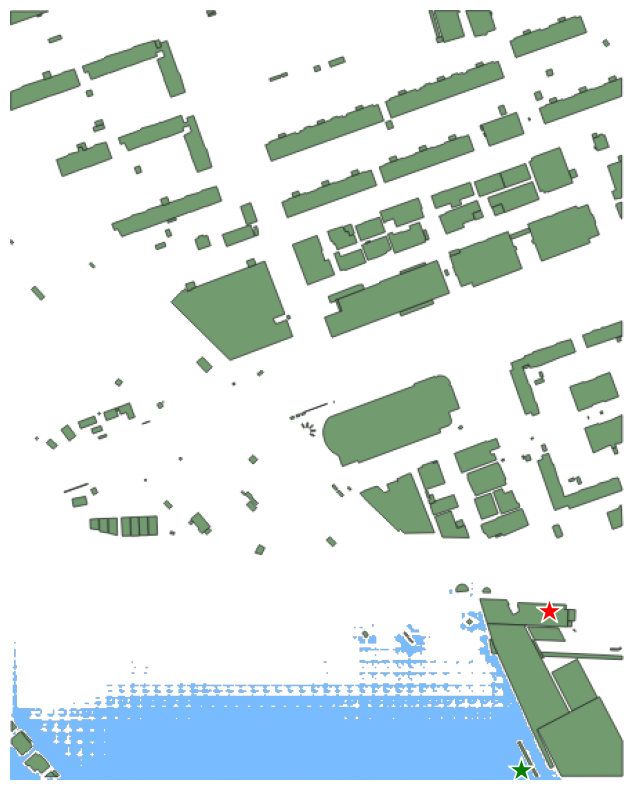

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

(1, 558, 445)

In [156]:
input_box = np.array([444, 555, 340, 425])

In [157]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

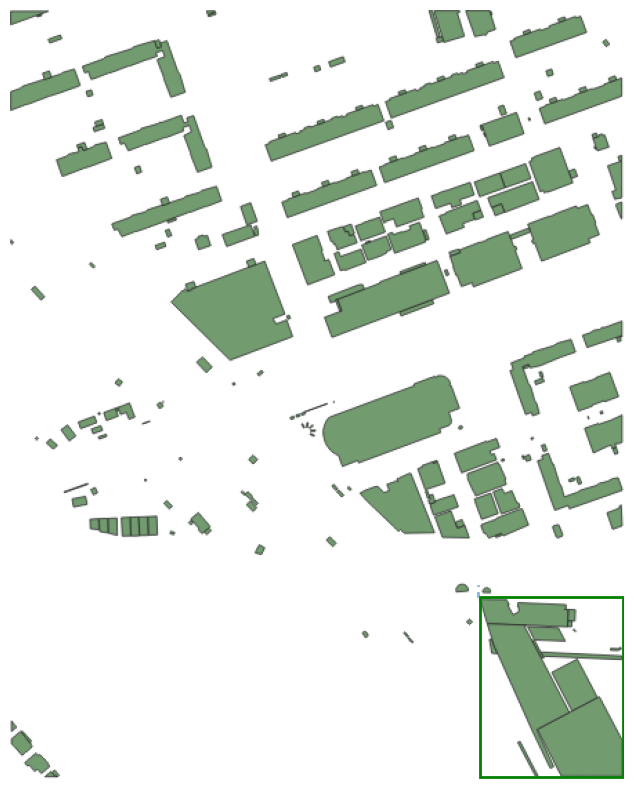

In [158]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [160]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [179]:
input_box = np.array([110, 250, 210, 180])
input_point = np.array([[180, 200]])
input_label = np.array([0])

In [180]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

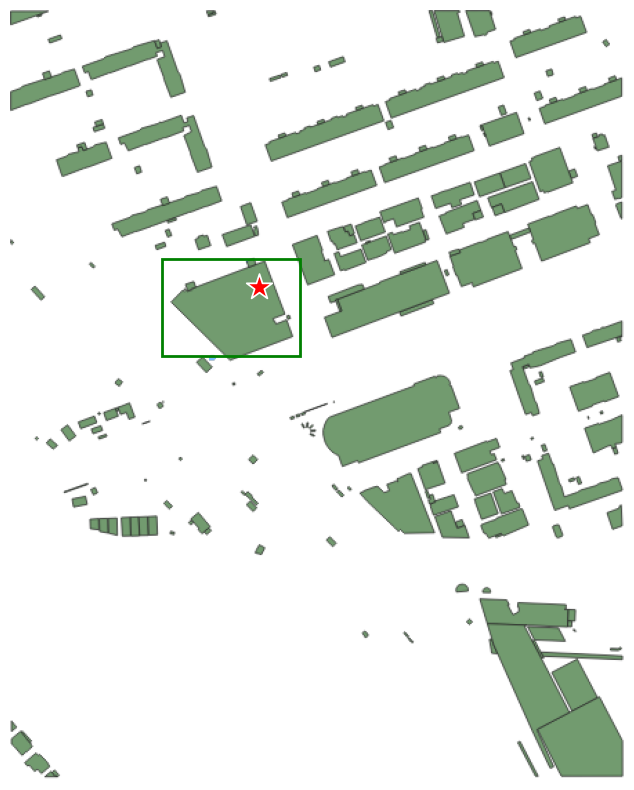

In [181]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [152]:
input_boxes = torch.tensor([
    [17, 142, 400, 440],
    [98, 310, 162, 453],
    [318, 284, 383, 414],
    [287, 349, 324, 387],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [153]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [154]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([4, 1, 558, 445])

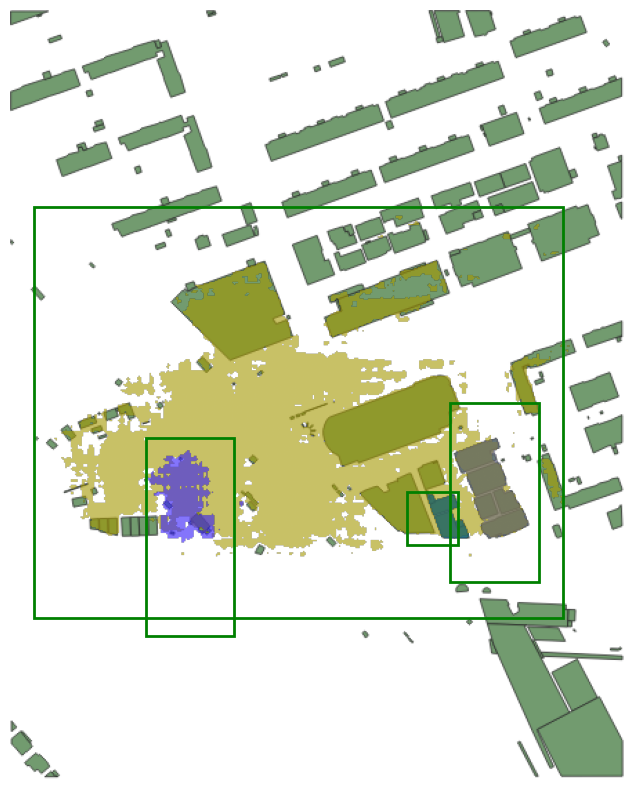

In [155]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

- Segment Anything 모델(SAM)이 예측한 여러 개의 마스크를 반복하면서 출력하는 부분이 있는 데, 이 여러 개의 마스크와 신뢰도가 같이 나옴 (score가 높을수록 당연히 정확도가 높은 후보라 판단)
- SAM은 다양한 크기와 형태의 객체를 동시에 감지할 수 있도록 설계되어, 동일한 포인트에서도 SAM은 "작은 영역, 중간 크기, 전체 물체" 등의 서로 다른 마스크를 제안할 수 있음
- 오히려 여기선 여러 폴리곤 객체로 분리된 하나의 건물을 인식하는 것이 필요하기 때문에 '전체 물체'를 포착할 수 있는 방법을 찾아야 함
- 또한, 이 코드는 수동으로 작동하며 automated generation code도 따로 있음
- **이렇게 mask를 만들고, polygon을 저장하는 형태 방식**

### 자동화 코드

Available keys in masks: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


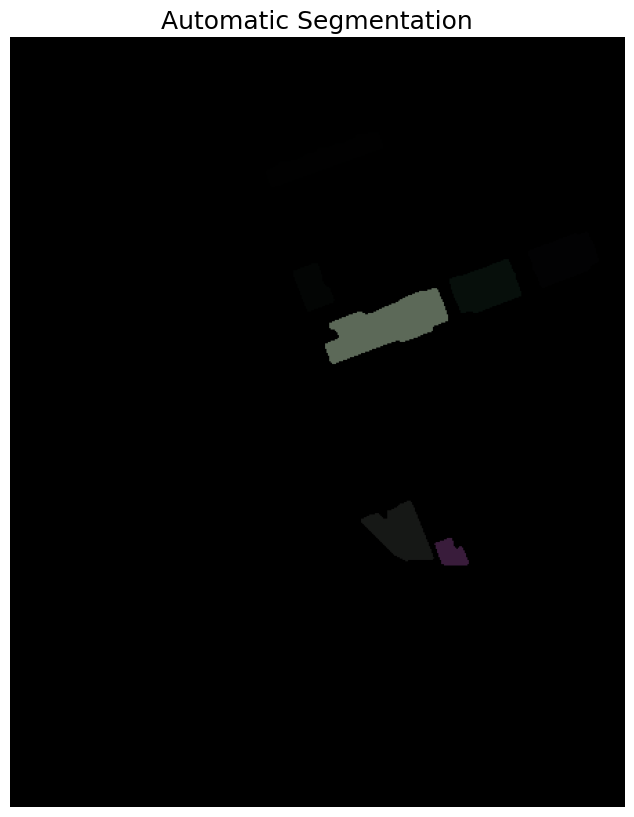

In [185]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# 모델 로드
sam_checkpoint = "sam_vit_h_4b8939.pth"  # 모델 가중치 파일
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# 자동 마스크 생성기 초기화
mask_generator = SamAutomaticMaskGenerator(sam)

# 이미지 로드
image_path = "/content/map.png"  # 여기에 이미지 경로 입력
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 자동 마스크 생성
masks = mask_generator.generate(image)

# 🔍 반환된 마스크의 키 확인 (디버깅용)
if len(masks) > 0:
    print("Available keys in masks:", masks[0].keys())

# ✅ score 키가 있으면 정렬, 없으면 그대로 사용
if "score" in masks[0]:
    masks = sorted(masks, key=lambda x: x["score"], reverse=True)

# 마스크 시각화 함수
def show_mask(mask, ax, alpha=0.8):
    color = np.random.rand(3) * 0.6 + 0.4  # 랜덤 색상
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image, alpha=alpha)

# 결과 시각화
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

for i, mask_data in enumerate(masks[:10]):  # 상위 10개 마스크만 표시
    show_mask(mask_data['segmentation'], plt.gca(), alpha=0.5)
    plt.title(f"Automatic Segmentation", fontsize=18)

plt.show()